In [1]:
# Download data
!wget -c https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data

--2024-02-23 12:54:17--  https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘iris.data’

iris.data               [ <=>                ]   4.44K  --.-KB/s    in 0s      

2024-02-23 12:54:19 (76.7 MB/s) - ‘iris.data’ saved [4551]



In [2]:
# task 1
import pandas as pd

iris_data = pd.read_csv('iris.data', header=None)
X = iris_data.iloc[:, :2].values

In [26]:
# task 2
import numpy as np
from scipy.stats import multivariate_normal

def setup_gmm_parameters(data, components_count, cov_type):
    np.random.seed(42)
    samples_count, feature_count = data.shape
    cluster_centers = data[np.random.choice(samples_count, components_count, False), :]
    
    def initialize_covariances():
        if cov_type == 'spherical':
            return [np.eye(feature_count) * np.var(data) for _ in range(components_count)]
        elif cov_type == 'diag':
            return [np.diag(np.var(data, axis=0)) for _ in range(components_count)]
        elif cov_type == 'tied':
            return [np.cov(data.T)] * components_count
        else:  # Full covariance
            return [np.cov(data.T) for _ in range(components_count)]
    
    initial_covariances = initialize_covariances()
    cluster_weights = np.full(components_count, 1 / components_count)
    return cluster_centers, initial_covariances, cluster_weights

def expectation_step(data, centers, covs, weights):
    components = len(weights)
    sample_size = data.shape[0]
    
    resp = np.zeros((sample_size, components))
    
    for idx in range(components):
        prob_density = multivariate_normal(mean=centers[idx], cov=covs[idx])
        resp[:, idx] = weights[idx] * prob_density.pdf(data)
    
    resp /= resp.sum(axis=1, keepdims=True)
    return resp

def maximization_step(data, resp, cov_type):
    sample_size, feature_count = data.shape
    components = resp.shape[1]
    
    new_centers = np.zeros((components, feature_count))
    new_covs = []
    new_weights = np.zeros(components)
    
    for idx in range(components):
        N_k = resp[:, idx].sum()
        new_centers[idx] = (resp[:, idx, np.newaxis] * data).sum(axis=0) / N_k
        
        data_centered = data - new_centers[idx]
        if cov_type == 'spherical':
            sigma = (np.sum(resp[:, idx] * (data_centered ** 2).sum(axis=1)) / N_k) * np.eye(feature_count)
        elif cov_type == 'diag':
            sigma = np.diag((resp[:, idx, np.newaxis] * (data_centered ** 2)).sum(axis=0) / N_k)
        elif cov_type == 'tied':
            if idx == 0:
                shared_sigma = np.zeros((feature_count, feature_count))
            shared_sigma += (resp[:, idx, np.newaxis] * data_centered).T @ data_centered
        else:  # Full covariance
            sigma = (resp[:, idx, np.newaxis] * data_centered).T @ data_centered / N_k
        
        if cov_type != 'tied':
            new_covs.append(sigma)
        
        new_weights[idx] = N_k / sample_size
    
    if cov_type == 'tied':
        shared_sigma /= sample_size
        new_covs = [shared_sigma] * components
    
    return new_centers, new_covs, new_weights

def fit_gmm(data, components, max_iters, cov_type='full'):
    centers, covs, weights = setup_gmm_parameters(data, components, cov_type)
    
    for iteration in range(max_iters):
        resp = expectation_step(data, centers, covs, weights)
        centers, covs, weights = maximization_step(data, resp, cov_type)
    
    return centers, covs, weights

# Example usage
components = 3
iterations = 100
centers, covariances, weights = fit_gmm(X, components, iterations, cov_type='full')

print(centers, covariances, weights)


[[6.34223677 2.86305692]
 [5.01587745 3.44426301]
 [6.1047519  2.87716132]] [array([[0.42928699, 0.04660978],
       [0.04660978, 0.09592497]]), array([[0.11956576, 0.08960608],
       [0.08960608, 0.1205545 ]]), array([[0.48781668, 0.22166172],
       [0.22166172, 0.13122913]])] [0.37130536 0.32106362 0.30763102]


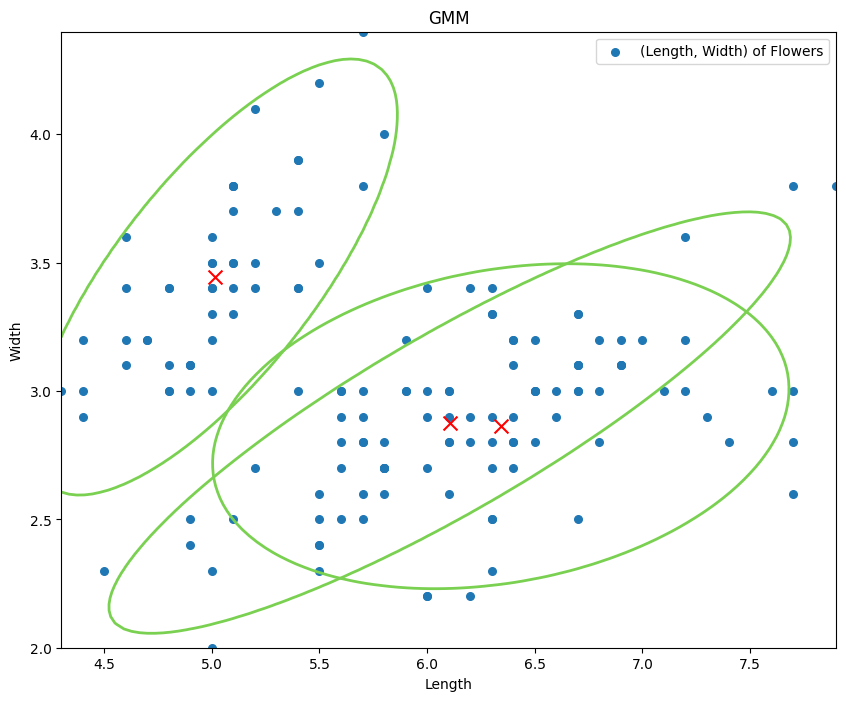

In [27]:
# task 2
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

plt.figure(figsize=(10, 8))
plt.scatter(X[:, 0], X[:, 1], s=30, marker='o', label='(Length, Width) of Flowers')

x, y = np.linspace(X[:,0].min(), X[:,0].max(), 100), np.linspace(X[:,1].min(), X[:,1].max(), 100)
X_grid, Y_grid = np.meshgrid(x, y)
XX = np.array([X_grid.ravel(), Y_grid.ravel()]).T

for i in range(components):
    ZZ = multivariate_normal(centers[i], covariances[i]).pdf(XX)
    ZZ = ZZ.reshape(X_grid.shape)
    plt.contour(X_grid, Y_grid, ZZ, levels=[0.1], norm=LogNorm(vmin=1.0e-5, vmax=1.0), linewidths=2)
    plt.scatter(centers[i][0], centers[i][1], color='red', s=100, marker='x')  # Mark the mean

plt.title('GMM')
plt.xlabel('Length')
plt.ylabel('Width')
plt.legend()
plt.show()


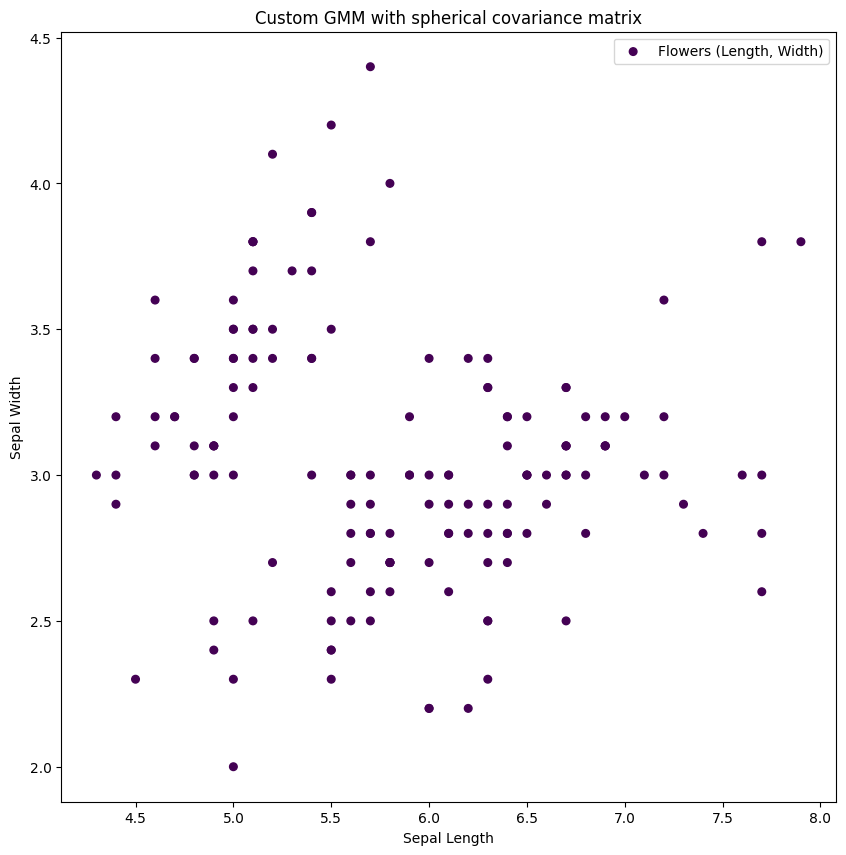

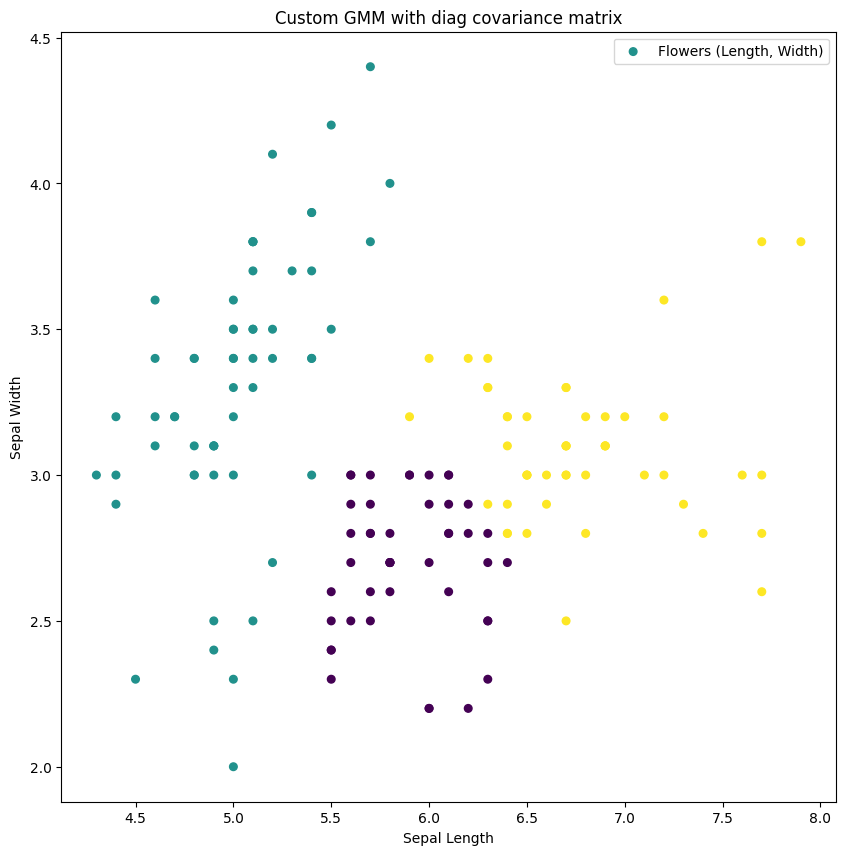

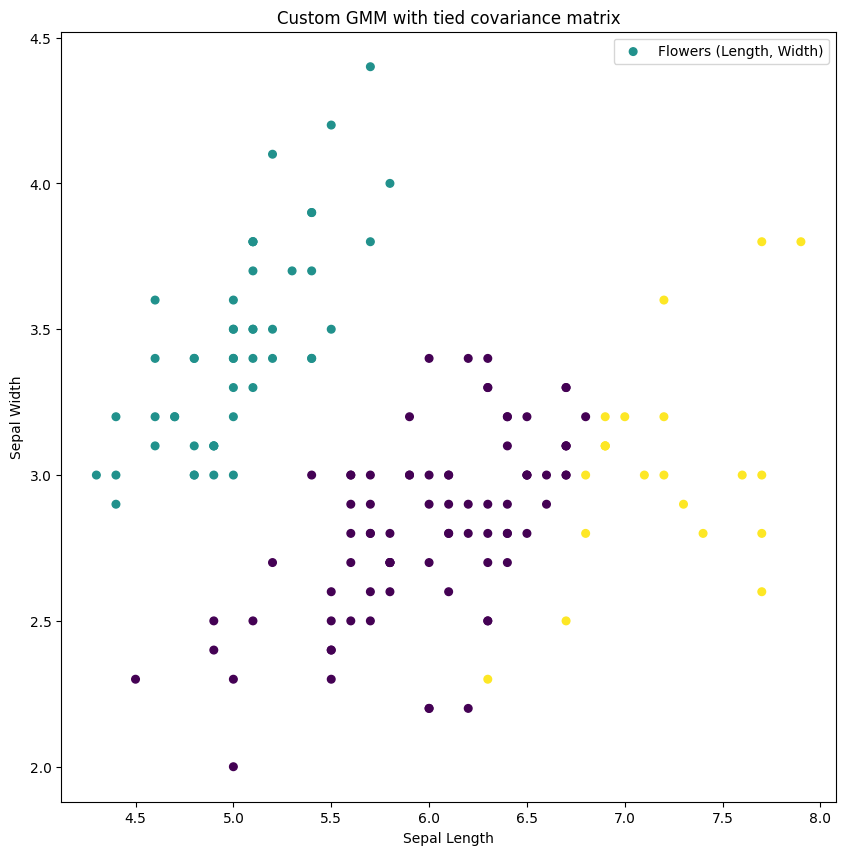

In [29]:
# task 2
def fit_and_plot_custom_gmm(X, cov_type):
    means, covariances, weights = fit_gmm(X, components, iterations, cov_type=cov_type)
    responsibilities = expectation_step(X, means, covariances, weights)
    labels = np.argmax(responsibilities, axis=1)
    
    plt.figure(figsize=(10, 10))
    plt.scatter(X[:, 0], X[:, 1], c=labels, s=30, cmap='viridis', marker='o', label='Flowers (Length, Width)') # plot
    plt.title(f'Custom GMM with {covariance_type} covariance matrix')
    plt.xlabel('Sepal Length')
    plt.ylabel('Sepal Width')
    plt.legend()
    plt.show()
    
for covariance_type in ['spherical', 'diag', 'tied']:
    fit_and_plot_custom_gmm(X, covariance_type)

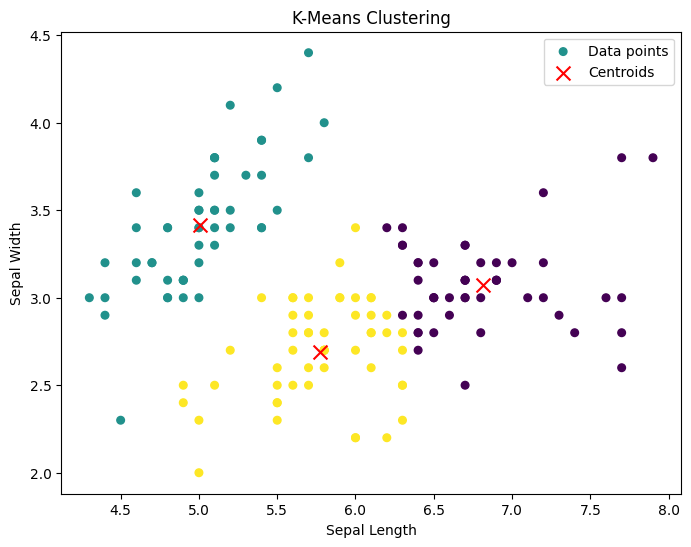

In [30]:
# task 3
def k_means(X, n_clusters, n_iters):
    n_samples, n_features = X.shape
    
    centroids = X[np.random.choice(n_samples, n_clusters, False), :]
    
    for _ in range(n_iters):
        distances = np.sqrt(((X - centroids[:, np.newaxis])**2).sum(axis=2))
        closest_centroid = np.argmin(distances, axis=0)
    
        for i in range(n_clusters):
            centroids[i] = X[closest_centroid == i].mean(axis=0)
    
    return centroids, closest_centroid


n_clusters = 3
n_iters = 100
centroids, labels = k_means(X, n_clusters, n_iters)


plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels, s=30, cmap='viridis', marker='o', label='Data points')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=100, marker='x', label='Centroids')
plt.title('K-Means Clustering')
plt.xlabel('Sepal Length')
plt.ylabel('Sepal Width')
plt.legend()
plt.show()


### Task 3
Diagonal convariance matrix in task 2 gives the most similar result to the k-means one.